<div class="alert alert-block alert-info">
    
# Model 3: Pretrained Embedding as classification task

https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

https://github.com/javaidnabi31/Word-Embeddding-Sentiment-Classification

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/?fbclid=IwAR1khMPlmKZhB9sW3y9kqmm3cYex6Rl5yDIyD8JGH677MJ5IP6wdmYoniZI

In [1]:
"""Module for loading the train and test data.

This module supports loading the data in two seperate ways.
The first, which is done by calling the load_train and load_test functions,
opens and parses the text files one by one. Because of the abundance of files,
this can take a while.
The second way of loading the data is by opening a pickle file containing the
results of the load_train and load_test functions. To create this pickle file,
call the create_data_pickle function once. Afterwards, you will be ablo to
quickly load the data using the load_data_pickle function.
"""
import collections
import glob
import os
import re
import warnings

#import utils


## Default data folder names ## 


DEFAULT_DATA_LOCATION = 'Data'
DEFAULT_TRAIN_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Train')
DEFAULT_TEST_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Test')

DEFAULT_PICKLE_PATH = os.path.join(DEFAULT_DATA_LOCATION, 'data.pkl')

PRICE_LOCATION_FILE_NAME = 'hotels.txt'
HOTEL_REVIEWS_FILE_TEMPLATE = 'Hotel_*.txt'
TEST_REVIEWS_FILE_TEMPLATE = '*.txt'


## Classes to store the parsed data in. ##


Hotel = collections.namedtuple(
  'Hotel', ['id', 'price', 'location'])
Review = collections.namedtuple(
  'Review', [
      'id', 'author', 'content', 'date', 'rating', 'subratings', 'hotel'])
Subratings = collections.namedtuple(
  'Subratings', [
      'value', 'rooms', 'location', 'cleanliness',
      'front_desk', 'service', 'business_service'])


## Helper functions for parsing data ##


def _parse_price_location_file(price_location_lines):
  hotels = {}
  for hotel_line in price_location_lines[1:]:
    tokens = hotel_line.strip().split(',')
    hotel_id = int(tokens[0])
    price = int(tokens[1])
    location = tokens[2]
    hotels[hotel_id] = Hotel(id=hotel_id, price=price, location=location)
  return hotels


def _extract_id_from_file_name(review_file_name):
  regex_res = re.findall('\d+', review_file_name)
  assert len(regex_res) == 1
  return int(regex_res[0])


_AUTHOR_TAG = '<Author>'
_CONTENT_TAG = '<Content>'
_DATE_TAG = '<Date>'
_RATING_TAG = '<Overall_rating>'
_SUBRATING_TAG = '<Subratings>'
_PRICE_TAG = '<Price>'
_LOCATION_TAG = '<Location>'


def _parse_string_line(line, tag):
  assert line.startswith(tag)
  return line.strip()[len(tag):]


def _parse_author_line(author_line):
  return _parse_string_line(author_line, _AUTHOR_TAG)


def _parse_content_line(content_line):
  return _parse_string_line(content_line, _CONTENT_TAG)


def _parse_date_line(date_line):
  return _parse_string_line(date_line, _DATE_TAG)


def _parse_rating_line(rating_line):
  rating_string = _parse_string_line(rating_line, _RATING_TAG)
  return int(rating_string)


def _parse_price_line(price_line):
  price_string = _parse_string_line(price_line, _PRICE_TAG)
  return int(price_string)


def _parse_location_line(location_line):
  return _parse_string_line(location_line, _LOCATION_TAG)


def _parse_subratings_line(subratings_line):
  subratings_string = _parse_string_line(subratings_line, _SUBRATING_TAG)
  subrating_tokens = subratings_string.split(',')

  subratings = {}
  for token in subrating_tokens:
    left, right = token.strip().split('=')
    subratings[left] = int(right)

  return Subratings(**subratings)


def _parse_single_hotel_review(review_lines, hotel):
  author_line, content_line, date_line, overall_rating_line, subratings_line = (
      review_lines)
  # Parse each of the lines
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  rating = _parse_rating_line(overall_rating_line)
  subratings = _parse_subratings_line(subratings_line)
  return Review(
      id=-1, author=author, content=content, date=date, rating=rating,
      subratings=subratings, hotel=hotel)


def _parse_hotel_review_file(hotel_review_lines, hotel):
  assert len(hotel_review_lines)%6 == 0
  hotel_reviews = []
  for start_idx in range(0, len(hotel_review_lines), 6):
    review_lines = hotel_review_lines[start_idx:start_idx+5]
    hotel_reviews.append(_parse_single_hotel_review(review_lines, hotel))
  return hotel_reviews


def _parse_test_review_file(test_review_lines, review_id):
  assert len(test_review_lines) == 5
  author_line, content_line, date_line, price_line, location_line = (
      test_review_lines)
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  price = _parse_price_line(price_line)
  location = _parse_location_line(location_line)
  unknown_hotel = Hotel(id=-1, price=price, location=location)
  review = Review(
      id=review_id, author=author, content=content, date=date, rating=-1,
      subratings=None, hotel=unknown_hotel)
  return review


## Functions for loading and parsing all of the data ##


def load_train(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION):
  """Loads and parses the train data.

  Args:
    train_data_folder: string containing the path to the folder containing the
        training data.

  Returns:
    A list of all the reviews. Each review is a namedtuple object containing
    the author, content, date, rating, subratings and hotel data. The hotel
    data is a namedtuple containing the price and location of the hotel.
    The subratings is a namedtuple containing the value, rooms, location,
    cleanliness, front_desk, service and business_service ratings. Different
    reviews of the same hotel will point to the same Hotel object.
  """
  price_location_file_path = os.path.join(
      train_data_folder, PRICE_LOCATION_FILE_NAME)
  review_file_paths = glob.glob(os.path.join(
      train_data_folder, HOTEL_REVIEWS_FILE_TEMPLATE))
  
  # First, load and parse the hotel price locations file
  with open(price_location_file_path, 'r') as price_location_file:
    price_location_lines = price_location_file.readlines()
  hotels_dict = _parse_price_location_file(price_location_lines)
  assert len(hotels_dict) == len(review_file_paths)
  
  # Second, load and parse each of the hotel review files
  reviews = []
  for review_file_path in review_file_paths:
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    hotel_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    hotel = hotels_dict[hotel_id]
    hotel_reviews = _parse_hotel_review_file(review_file_lines, hotel)
    reviews += hotel_reviews
  return reviews


def load_test(test_data_folder=DEFAULT_TEST_DATA_LOCATION):
  """Loads and parses the test data.

  Args:
    test_data_folder: string containing the path to the folder containing the]
        test data.

  Returns:
    A list of all the test reviews, sorted by the review id. Each review is a
    namedtuple object containing the author, content, date and hotel data. The
    hotel data is a namedtuple containing the price and location of the hotel.
    Since the hotel id is unknown, different reviews of the same hotel will 
    point to different Hotel objects.
  """
  review_file_paths = glob.glob(os.path.join(
      test_data_folder, TEST_REVIEWS_FILE_TEMPLATE))
  # Parse all the review files one by one
  reviews = []
  for review_file_path in review_file_paths:
    review_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    reviews.append(_parse_test_review_file(review_file_lines, review_id))
  # Sort them by review id
  key_getter = lambda r: r.id
  reviews.sort(key=key_getter)
  #assert range(1, len(reviews)+1) == map(key_getter, reviews)
  return reviews


## Functions for loading the data from a pickle file. ##


def create_pickled_data(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION,
                        test_data_folder=DEFAULT_TEST_DATA_LOCATION,
                        pickled_data_file_path=DEFAULT_PICKLE_PATH,
                        overwrite_old=True):
  """Creates the data pickle file.

  Loads and parses the train and test data, and then writes it to a single
  pickle file.

  Args: 
    train_data_folder: path to the train data folder.
    test_data_folder: path to the test data folder.
    pickled_data_file_path: location where the resulting pickle file should
        be stored.
  """
  if os.path.exists(pickled_data_file_path):
    if not overwrite_old:
      return 
    warnings.warn(
        "There already exists a data pickle file, which will be overwritten.")
  train_data = load_train(train_data_folder)
  test_data = load_test(test_data_folder)
  utils.dump_pickle(
      dict(train=train_data, test=test_data), pickled_data_file_path)


def load_pickled_data(pickled_data_file_path=DEFAULT_PICKLE_PATH):
  """Loads the train and test data from a pickle file.

  Args:
    pickled_data_file_path: location of the data pickle file.
  """
  return utils.load_pickle(pickled_data_file_path)



Number of reviews with a rating of 1: 12079
Number of reviews with a rating of 2: 15991
Number of reviews with a rating of 3: 20386
Number of reviews with a rating of 4: 61926
Number of reviews with a rating of 5: 84297


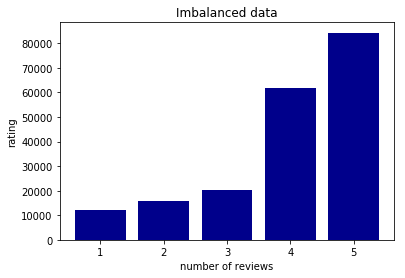

In [3]:
Train = load_train(DEFAULT_TRAIN_DATA_LOCATION)
i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(Train)):
    if Train[i][4] == 1:
        i1 += 1
    if Train[i][4] == 2:
        i2 += 1
    if Train[i][4] == 3:
        i3 += 1
    if Train[i][4] == 4:
        i4 += 1
    if Train[i][4] == 5:
        i5 += 1
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('Imbalanced data') 
  
# function to show the plot 
plt.show() 

**As we can see the reviews are imbalanced so we will balance the dataset that we are going to use by undersampling**

In [4]:
rating1=[]
rating2=[]
rating3=[]
rating4=[]
rating5=[]
for i in range(len(Train)):
    if Train[i][4] == 1:
        rating1.append(Train[i])
    if Train[i][4] == 2:
        rating2.append(Train[i])
    if Train[i][4] == 3:
        rating3.append(Train[i])
    if Train[i][4] == 4:
        rating4.append(Train[i])
    if Train[i][4] == 5:
        rating5.append(Train[i])

import random

random.shuffle(rating1)
random.shuffle(rating2)
random.shuffle(rating3)
random.shuffle(rating4)
random.shuffle(rating5)

subrating1 = rating1
subrating2 = rating2[0:len(rating1)]
subrating3 = rating3[0:len(rating1)]
subrating4 = rating4[0:len(rating1)]
subrating5 = rating5[0:len(rating1)]

subtrain = subrating1 + subrating2 + subrating3 + subrating4 + subrating5
random.shuffle(subtrain)

print(len(subtrain))

60395


### Make contentlist , rating list and Hotel_id list

In [5]:
#Train = subtrain
#Put the content of each review into a list
import random
#Train = Train[0:30000]
random.shuffle(Train)

RealRating = list()
for i in range(len(Train)):
    if Train[i][4]!=-1:
        RealRating.append(Train[i])

Train = RealRating

content_list = list()

for i in range(len(Train)):
    if Train[i][4]==str(-1):
        del Train[i]

for i in range(len(list(Train))):
    content=(list(list(Train[i]))[2])
    content_list.append(content)

rating_list = list()

for i in range(len(list(Train))):
    rating =list(Train[i])[4]
    rating = rating - 1
    rating_list.append(rating)
    
Hotel_id_list = list()

for i in range(len(list(Train))):
    Hotel_id=(list(list(Train[i]))[6][0])
    Hotel_id_list.append(Hotel_id)

### Language detection: only English reviews

In [6]:
!pip install langdetect
from langdetect import detect
language = detect(content_list[0])
print(language)


notenglish = list()
nolanguage = list()
for i in range(len(content_list)):  #len(content_list)
    
    try:
    #language = detect(content_list[i])
        if( detect(content_list[i]) != 'en'):
            notenglish.append(i)
        
    except:
        nolanguage.append(i)
        
        
mergedlist = notenglish + nolanguage
print(mergedlist)

mergedlist.sort()
print(mergedlist)


times = 0
for i in range(len(mergedlist)): 
    content_list.pop(mergedlist[i] - times)
    rating_list.pop(mergedlist[i] - times)
    times = times + 1 

    

en
[5, 17, 30, 38, 39, 43, 45, 56, 68, 80, 82, 84, 99, 114, 116, 120, 132, 133, 137, 139, 140, 147, 163, 167, 178, 187, 192, 200, 204, 209, 211, 212, 226, 235, 240, 248, 250, 252, 255, 266, 287, 295, 299, 300, 306, 314, 319, 320, 328, 329, 338, 340, 344, 368, 371, 384, 391, 393, 405, 409, 417, 424, 427, 440, 446, 449, 460, 461, 462, 463, 470, 478, 481, 485, 491, 492, 498, 505, 520, 521, 532, 540, 543, 549, 552, 561, 574, 575, 577, 579, 611, 614, 615, 617, 619, 624, 652, 655, 657, 664, 668, 673, 675, 699, 712, 716, 718, 725, 729, 730, 731, 743, 746, 749, 761, 767, 779, 781, 784, 790, 797, 804, 821, 824, 854, 856, 866, 882, 895, 896, 899, 900, 917, 928, 932, 942, 943, 947, 957, 986, 992, 996, 997, 1010, 1012, 1023, 1024, 1029, 1035, 1037, 1046, 1050, 1051, 1053, 1056, 1057, 1058, 1061, 1072, 1089, 1107, 1110, 1136, 1142, 1146, 1149, 1156, 1158, 1163, 1164, 1168, 1174, 1177, 1178, 1179, 1186, 1193, 1200, 1202, 1210, 1213, 1222, 1230, 1231, 1232, 1233, 1242, 1248, 1249, 1258, 1269, 1274, 1

In [7]:
len(notenglish)

31553

In [8]:
len(nolanguage)

574

### Lemitization

In [9]:
!pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

for i in range(len(content_list)):
    listlemmatizer = list()
    input_str = word_tokenize(content_list[i]) # Puts every word of the string situated in content_list[i] seperately into a list
    for word in input_str:
        lem = lemmatizer.lemmatize(word)
        listlemmatizer.append(lem)
    content_list[i] = ' '.join(listlemmatizer) # Puts the seperate words back into one string where the words are seperated by one space ' '
    
print(content_list[1:10])

['Not a great place to stay This place is falling apart ... wa once a nice little place to stay but not now . Lobby wa shabby and dirty , room wa not better ... there wa mold in the tub , no movie here to buy on cable , iron in room wa broke ... .etc . For the $ 160 they charged per night ( with a AAA card ) , I would not go back ... there is a very nice small , totally remodeled motel two block down that we should have stayed at for the same price and most definitly will next time ... It is called Hotel Del Sol ... check it out , thehoteldelsol.com ... .much , much better for the $ $ $ $ .', 'Do not book this hotel Hotel Argentina Florence Do not stay hereMy husband and I booked a 2 night stay in May . We were told that they had no electrity on the 2nd floor so they had booked u into a better hotel . We travelled acoss the city to find a grotty 2 star hotell and not the 4 star a promised . We phone tha Argentina and Andre Gardenti had the cheek to say the hotel had just been awarded a

### Define a vocabulary and only save those words in the content list

In [10]:

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

words = list()
for i in range(len(content_list)):
    input_str = word_tokenize(content_list[i])
    for word in input_str:
         words.append(word)
    
vocab = collections.Counter(words)

print(vocab.most_common(100))
print(vocab)

# keep tokens with a min occurrence
min_occurance = 100
word_bag = [k for k,c in vocab.items() if c >= min_occurance]
print(len(word_bag))

for i in range(len(content_list)): #len(content_list)
    tokens = word_tokenize(content_list[i])
    result = [w for w in tokens if w in word_bag]
    content_list[i] = ' '.join(result)
content_list[1:10]



[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('the', 1657513), ('.', 1490188), (',', 1158639), ('and', 1039805), ('a', 947024), ('to', 772121), ('wa', 608340), ('in', 459229), ('of', 449793), ('I', 415480), ('is', 382147), ('for', 341391), ('The', 333512), ('hotel', 321864), ('we', 317095), ('room', 307522), ('it', 295113), ('!', 266496), ('at', 266095), ('you', 259474), ('were', 256037), ('with', 223313), ('on', 219589), ('that', 219224), ('but', 218795), ('not', 193502), ('very', 193116), ('We', 190458), ('had', 180156), ('are', 170289), (')', 167450), ('this', 165212), ('(', 161366), ('our', 156884), ('have', 153383), ('from', 146472), ('there', 130018), ("n't", 127439), ('they', 117313), ('be', 115581), ('all', 114573), ('great', 112703), ('would', 107571), ('so', 104749), ('stay', 104331), ('-', 101911), ('good', 99935), ('staff', 99928), ('my', 95218), ('night', 92418), ('did', 90087), ('one', 88636), ("'s", 83826), ('which', 82617), ('u', 82244), ('time', 81640), ('day', 80576), ('get', 76748), ('if', 76384), ('out', 7600

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['Not a great place to stay This place is falling apart ... wa once a nice little place to stay but not now . Lobby wa shabby and dirty , room wa not better ... there wa mold in the tub , no movie here to buy on cable , iron in room wa broke ... . For the $ 160 they charged per night ( with a AAA card ) , I would not go back ... there is a very nice small , totally remodeled motel two block down that we should have stayed at for the same price and most definitly will next time ... It is called Hotel Del Sol ... check it out , ... , much better for the $ $ $ $ .',
 'Do not book this hotel Hotel Florence Do not stay husband and I booked a 2 night stay in May . We were told that they had no on the 2nd floor so they had booked u into a better hotel . We travelled the city to find a 2 star and not the 4 star a promised . We phone and had the to say the hotel had just been a 3rd star that day . Total lie . Our stay in Florence wa totally ruined by this hotel . We also think they had just dou

### To dataframe

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


df = pd.DataFrame.from_dict(content_list)
df.columns = ['Review']
df.head(5)

df2 = pd.DataFrame.from_dict(rating_list)
df['Rating'] = df2

df['Hotel_id'] = pd.DataFrame.from_dict(Hotel_id_list, dtype = 'category')

df.head(20)



,Review,Rating,Hotel_id
0,A Pleasant Stay The is in a peaceful section o...,3,1214
1,Not a great place to stay This place is fallin...,1,844
2,Do not book this hotel Hotel Florence Do not s...,0,650
3,Excellent discounted room I 've just stayed tw...,4,216
4,A `` Best `` in Florence I do n't believe you ...,4,1284
5,Modern sleek new San Francisco This is a beaut...,4,1355
6,Enjoyed our one week stay at the Red Lion We j...,3,807
7,Great hotel and great location This is a great...,3,848
8,"Fantastic Hotel , great location My partner an...",4,851
9,Terrible service ! We read the review and look...,0,1390


### Some Preprocessing

In [12]:
!pip install nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

review_lines = list()
lines = df['Review'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
df['review_lines'] = review_lines

In [14]:
total_reviews = df.loc[:,'Review'].values
max_length = max([len(s.split()) for s in total_reviews])

## Wikipedia Embedding

In [15]:
!pip install bz2file

import os
import bz2
embeddings_index = {}
#f = bz2.open("enwiki_20180420_win10_100d.txt.bz2", "rt")
f = bz2.open('enwiki_20180420_win10_100d.txt.bz2', mode='rt', compresslevel=9, encoding=None, errors=None, newline=None)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [16]:
len(df['Rating'])

164412

In [17]:
X_train = df.loc[:(len(df['Rating'])/2)-1,'Review'].values
len(X_train)
y_train = df.loc[:(len(df['Rating'])/2)-1, 'Rating'].values
X_test = df.loc[len(df['Rating'])/2:len(df['Rating']), 'Review'].values
y_test = df.loc[len(df['Rating'])/2:len(df['Rating']), 'Rating'].values

In [18]:
total_reviews = X_train + X_test
max_length = max([len(s.split()) for s in total_reviews])

## Split in train and validation data

In [19]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
print(df.head(5))

import numpy as np

# Group the reviews per hotel, and count how many reviews there are per hotel
reviews_per_hotel = df.groupby('Hotel_id').count().sort_values(by = 'Hotel_id',ascending=False)
# Select 3/4ths of the hotel indices to be in the train set, and the remaining 1/4th in the test set
train_idxs = np.random.choice(len(reviews_per_hotel), int(len(reviews_per_hotel)*3/4), replace=False)
test_idxs = [i for i in range(len(reviews_per_hotel)) if i not in train_idxs]
# Split the dataframe with the hotels and their resp. number of reviews into a train and a test part
hotels_train = reviews_per_hotel.iloc[train_idxs]
hotels_test  = reviews_per_hotel.iloc[test_idxs]
N_train = hotels_train.sum()
N_test = hotels_test.sum()
print('{} reviews in the train set, {} reviews in the validation set, fraction {}'.format(N_train, N_test, N_test / (N_train)))

# Create the train and validation set
df_train = df.loc[df['Hotel_id'].isin(list(hotels_train.index))].reset_index(drop=True)
df_val = df.loc[df['Hotel_id'].isin(list(hotels_test.index))].reset_index(drop=True)
'''
VALIDATION_SPLIT = 0.25
import numpy as np

# Group the reviews per hotel, and count how many reviews there are per hotel
reviews_per_hotel = df.groupby('Hotel_id').count().sort_values(by = 'Hotel_id',ascending=False)

print(reviews_per_hotel)
print(len(reviews_per_hotel))

hotels_train = reviews_per_hotel[0:int(len(reviews_per_hotel)*(1-VALIDATION_SPLIT))]
hotels_test  = reviews_per_hotel[int(len(reviews_per_hotel)*(1-VALIDATION_SPLIT)):len(reviews_per_hotel)]
N_train = hotels_train.sum()
N_test = hotels_test.sum()
#print(hotels_train.head(5))


#hotels_train = hotels_train.sample(frac=1)
#print(hotels_train.head(5))
#hotels_test = hotels_test.sample(frac=1)

df_train = df.loc[df['Hotel_id'].isin(list(hotels_train.index))].reset_index(drop=True)
df_val = df.loc[df['Hotel_id'].isin(list(hotels_test.index))].reset_index(drop=True)

df_train = df_train.sample(frac=1)
df_val = df_val.sample(frac=1)
'''
# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_train['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_train['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_train['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_train_pad = review_pad
y_train = sentiment


# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_val['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_val['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_val['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_test_pad  = review_pad
y_test = sentiment

#num_validation_samples = int(N_test[0])

#X_train_pad = review_pad[:-num_validation_samples]
#y_train = sentiment[:-num_validation_samples]
#X_test_pad = review_pad[-num_validation_samples:]
#y_test = sentiment[-num_validation_samples:]

                                              Review  Rating  Hotel_id  \
0  A Pleasant Stay The is in a peaceful section o...       3      1214   
1  Not a great place to stay This place is fallin...       1       844   
2  Do not book this hotel Hotel Florence Do not s...       0       650   
3  Excellent discounted room I 've just stayed tw...       4       216   
4  A `` Best `` in Florence I do n't believe you ...       4      1284   

                                        review_lines  
0  [pleasant, stay, peaceful, section, city, two,...  
1  [great, place, stay, place, falling, apart, wa...  
2  [book, hotel, hotel, florence, stay, husband, ...  
3  [excellent, discounted, room, stayed, two, nig...  
4  [best, florence, nt, believe, find, better, ho...  
Review          124852
Rating          124852
review_lines    124852
dtype: int64 reviews in the train set, Review          39560
Rating          39560
review_lines    39560
dtype: int64 reviews in the validation set, fractio

In [20]:
df_train.head(10)
#df_val.head(1000)

,Review,Rating,Hotel_id,review_lines
0,Do not book this hotel Hotel Florence Do not s...,0,650,"[book, hotel, hotel, florence, stay, husband, ..."
1,A `` Best `` in Florence I do n't believe you ...,4,1284,"[best, florence, nt, believe, find, better, ho..."
2,Enjoyed our one week stay at the Red Lion We j...,3,807,"[enjoyed, one, week, stay, red, lion, returned..."
3,Great hotel and great location This is a great...,3,848,"[great, hotel, great, location, great, hotel, ..."
4,Ohana East I stayed at the Ohana East for the ...,3,889,"[ohana, east, stayed, ohana, east, first, time..."
5,"Not good . As a former San , I chose the Hotel...",0,906,"[good, former, san, chose, hotel, triton, funk..."
6,Great in a Great Location At the last minute w...,4,297,"[great, great, location, last, minute, able, e..."
7,Wonderful boutique hotel Great boutique hotel ...,4,747,"[wonderful, boutique, hotel, great, boutique, ..."
8,Outstanding My boyfriend and I took a week lon...,4,394,"[outstanding, boyfriend, took, week, long, roa..."
9,Simply the finest city hotel in Asia From star...,4,660,"[simply, finest, city, hotel, asia, start, fin..."


In [21]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (124852, 7873)
Shape of y_train tensor: (124852,)
Shape of X_test_pad tensor: (39560, 7873)
Shape of y_test tensor: (39560,)


Distribution of the ratings in the training set:
Number of reviews with a rating of 1: 8285
Number of reviews with a rating of 2: 10878
Number of reviews with a rating of 3: 12819
Number of reviews with a rating of 4: 37886
Number of reviews with a rating of 5: 54983


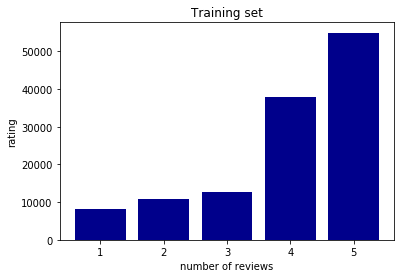

Distribution of the ratings in the validation set:
Number of reviews with a rating of 1: 2677
Number of reviews with a rating of 2: 3400
Number of reviews with a rating of 3: 4125
Number of reviews with a rating of 4: 12109
Number of reviews with a rating of 5: 17249


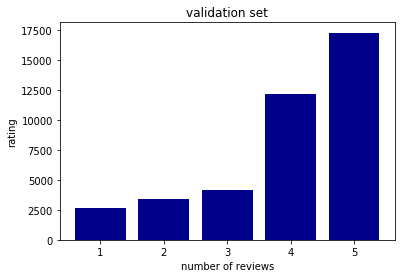

In [22]:

i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(y_train)):
    if y_train[i] == 0:
        i1 += 1
    if y_train[i] == 1:
        i2 += 1
    if y_train[i] == 2:
        i3 += 1
    if y_train[i] == 3:
        i4 += 1
    if y_train[i] == 4:
        i5 += 1
print('Distribution of the ratings in the training set:')
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('Training set') 
  
# function to show the plot 
plt.show() 


i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(y_test)):
    if y_test[i] == 0:
        i1 += 1
    if y_test[i] == 1:
        i2 += 1
    if y_test[i] == 2:
        i3 += 1
    if y_test[i] == 3:
        i4 += 1
    if y_test[i] == 4:
        i5 += 1
print('Distribution of the ratings in the validation set:')
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('validation set') 
  
# function to show the plot 
plt.show() 

In [23]:
y_test[1:10]

array([1, 4, 4, 4, 0, 2, 3, 3, 4])

**Set class weights for imbalanced classes**

In [174]:
class_weightstrain = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weightstrain.shape)
class_weightstrain

(5,)


array([ 3.14275093,  2.22473684,  1.89127517,  0.67470072,  0.45015974])

In [25]:
import keras
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_test.shape

Using TensorFlow backend.


(39560, 5)

In [26]:
y_train[0:10]

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.]], dtype=float32)

In [34]:
'''

class_weightstrain = {"[ 0.,  0.,  0.,  0.,  0.]": 3.14275093,
                "[ 0.,  1.,  0.,  0.,  0.]": 2.22473684,
                "[ 0.,  0.,  1.,  0.,  0.]": 1.89127517,
               "[ 0.,  0.,  0.,  1.,  0.]": 0.67470072,
               "[ 0.,  0.,  0.,  0.,  1.]": 0.45015974}
               
'''

In [27]:
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
!pip install numpy

## CuDNNLSTM model

In [29]:

from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import LSTM, CuDNNLSTM
np.random.seed(7)
from keras import regularizers
from keras import constraints
from keras.constraints import max_norm
model_1_v3_savename = 'TripAdvisor_wikidembeddinglstm_modelalldata_0.3.h5'

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(CuDNNLSTM(100,return_sequences=False, stateful = False))
model.add(Dense(5, activation='softmax'))
#Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callbacks = [
             ModelCheckpoint(model_1_v3_savename, monitor='val_acc', verbose=2, 
                             save_best_only=True)]
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=100, validation_data=(X_test_pad, y_test),
                    class_weight=class_weightstrain,verbose=1, callbacks = callbacks)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 7873, 100)         674600    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 755,905
Trainable params: 81,305
Non-trainable params: 674,600
_________________________________________________________________
None
Train on 124852 samples, validate on 39560 samples
Epoch 1/100
124852/124852 [==============================] - 342s 3ms/step - loss: 1.2476 - acc: 0.4582 - val_loss: 1.1943 - val_acc: 0.4786

Epoch 00001: val_acc improved from -inf to 0.47859, saving model to TripAdvisor_wikidembeddinglstm_modelalldata_0.3.h5
Epoch 2/100
124852/124852 [==============================] - 337s 3ms/step - l


Epoch 00038: val_acc did not improve from 0.51092
Epoch 39/100
124852/124852 [==============================] - 337s 3ms/step - loss: 0.7082 - acc: 0.6941 - val_loss: 1.6974 - val_acc: 0.4263

Epoch 00039: val_acc did not improve from 0.51092
Epoch 40/100
124852/124852 [==============================] - 338s 3ms/step - loss: 0.7052 - acc: 0.6940 - val_loss: 1.7210 - val_acc: 0.4290

Epoch 00040: val_acc did not improve from 0.51092
Epoch 41/100
124852/124852 [==============================] - 337s 3ms/step - loss: 0.7046 - acc: 0.6954 - val_loss: 1.7126 - val_acc: 0.4248

Epoch 00041: val_acc did not improve from 0.51092
Epoch 42/100
124852/124852 [==============================] - 337s 3ms/step - loss: 0.6979 - acc: 0.6990 - val_loss: 1.7719 - val_acc: 0.4132

Epoch 00042: val_acc did not improve from 0.51092
Epoch 43/100
124852/124852 [==============================] - 338s 3ms/step - loss: 0.6897 - acc: 0.7014 - val_loss: 1.7101 - val_acc: 0.4226

Epoch 00043: val_acc did not impro

In [30]:
model.load_weights(model_1_v3_savename)
score_val = model.evaluate(X_test_pad, y_test, verbose=0)
print('Validation loss:', score_val[0])
print('Validation accuracy:', score_val[1])

Validation loss: 1.16228640844
Validation accuracy: 0.510920121335


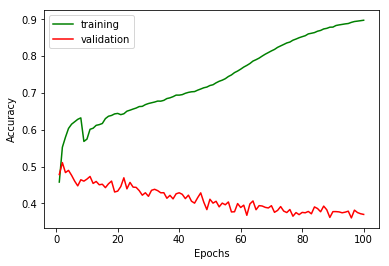

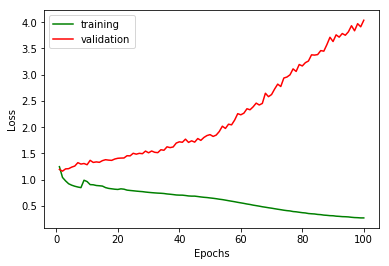

In [31]:


import matplotlib.pyplot as plt

#real_epochs = 100

real_epochs = len(history.history['acc'])
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#plt.figure()
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['loss'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_loss'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [32]:
max_length

7873

## Confusion matrix on validation data

In [33]:
y_prediction = model.predict(X_test_pad)
y_prediction[0]

test_predicted_class = np.argmax(y_prediction,axis=1)
test_predicted_class[0]
len(test_predicted_class)

#y_train = rating_list
#x_val = x_train[:round(0.3*len(Train))]
#y_val = y_train[:round(0.3*len(Train))]

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_val['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_val['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_val['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_test_pad  = review_pad
y_test2 = sentiment






Found 6745 unique tokens.
Shape of review tensor: (39560, 7873)
Shape of sentiment tensor: (39560,)


In [34]:
'''
print(round(y_prediction[2000][0]))

print(len(y_prediction))
print(len(y_test2))

ypredictions = list()
for i in range(len(y_prediction)):
    result = round(y_prediction[i][0])
    ypredictions.append(result)

ypredictions
'''

'\nprint(round(y_prediction[2000][0]))\n\nprint(len(y_prediction))\nprint(len(y_test2))\n\nypredictions = list()\nfor i in range(len(y_prediction)):\n    result = round(y_prediction[i][0])\n    ypredictions.append(result)\n\nypredictions\n'

Confusion matrix, without normalization


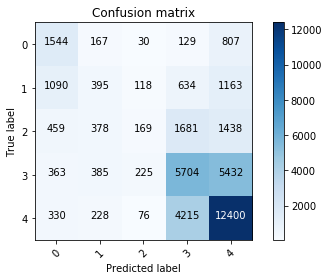

In [35]:

# You can use the code below to plot a confusion matrix


from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(y_test2, test_predicted_class) #voor mae: ypredictions

## Misclassifications

In [57]:
df_val.iloc[0]

Review          A Pleasant Stay The is in a peaceful section o...
Rating                                                          3
Hotel_id                                                     1214
review_lines    [pleasant, stay, peaceful, section, city, two,...
Name: 0, dtype: object

In [69]:
for i in range(100):
    result1 = test_predicted_class[i]
    result2 = df_val.iloc[i][1]
    if (result1 != result2):
        print(" Predicted rating: ", result1, "\n", "True rating: ", result2 , "\n", "Review: ",df_val.iloc[i][0], "\n")

 Predicted rating:  4 
 True rating:  1 
 Review:  Not a great place to stay This place is falling apart ... wa once a nice little place to stay but not now . Lobby wa shabby and dirty , room wa not better ... there wa mold in the tub , no movie here to buy on cable , iron in room wa broke ... . For the $ 160 they charged per night ( with a AAA card ) , I would not go back ... there is a very nice small , totally remodeled motel two block down that we should have stayed at for the same price and most definitly will next time ... It is called Hotel Del Sol ... check it out , ... , much better for the $ $ $ $ . 

 Predicted rating:  3 
 True rating:  4 
 Review:  Excellent discounted room I 've just stayed two night in Darling Harbour with my son at Inn on Harbour St , opposite the Entertainment Centre ( which wa therefore the view ) and next to a monorail stop , the tram line and 's . It wa amazingly quiet a the road directly outside seems to be a restricted access one with hardly any t